# COMP90051 Project 2

In [1]:
# Do not edit. These are the only imports permitted.
%matplotlib inline
import numpy as np
from numpy.linalg import inv
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

## 1. Implementing ε-Greedy and UCB

In [2]:
class MAB(ABC):
    """
    Abstract class that represents a multi-armed bandit (MAB)
    """
    
    @abstractmethod
    def play(self, tround, context):
        """
        Play a round
        
        Arguments
        =========
        tround : int
            positive integer identifying the round
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to the arms
        
        Returns
        =======
        arm : int
            the positive integer arm id for this round
        """
    
    @abstractmethod
    def update(self, arm, reward, context):
        """
        Updates the internal state of the MAB after a play
        
        Arguments
        =========
        arm : int
            a positive integer arm id in {1, ..., self.narms}

        reward : float
            reward received from arm
        
        context : 1D float array, shape (self.ndims * self.narms), optional
            context given to arms
        """

In [3]:
class EpsGreedy(MAB):
    """
    Epsilon-Greedy multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    epsilon : float
        explore probability

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, epsilon, Q0=np.inf):
        
        #pramater validation check
        assert epsilon<=1 and epsilon >=0, "epsilon should be between 0 and 1"
        assert narms > 0, "narms should be bigger than 0"
        self.narms = narms
        self.epsilon = epsilon
        self.Q0 = Q0
        
        #initialize the count of all arms to be zero
        self.count = np.zeros(narms)
        
        #initialize Q values to be Q0
        self.Q = np.full((1,narms),self.Q0)
      
        
    def play(self, tround, context=None):
        """
        Arguments
        =========
        tround : int
        context : None
        
        Return
        =========
        arm: int  the arm to play
        """
        
        if np.random.random() > self.epsilon:
            preQ = self.Q[tround-1]
            best_Q = max(preQ)
            best_arms = [arm for arm in range(self.narms) if preQ[arm] == best_Q]
            return np.random.choice(best_arms) + 1
        
        else:
            return np.random.choice(list(range(0,self.narms))) + 1
        
                             
    def update(self, arm, reward, context=None):
        """
        Arguments
        =========
        arm : int, between 1-10 for this specific setting
        reward : int
        context:None

        """
        
        arm -= 1
        Q = self.Q[-1][:]
        if self.count[arm] > 0:
            total_rewards = Q[arm] * self.count[arm] + reward
            self.count[arm] += 1
            Q[arm] = (total_rewards)/(self.count[arm])
        else:
            Q[arm] = reward
            self.count[arm] += 1
        
        #Append updated Q to history
        self.Q = np.vstack((self.Q,Q))
       
     
    

In [4]:
class UCB(MAB):
    """
    Upper Confidence Bound (UCB) multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    rho : float
        positive real explore-exploit parameter

    Q0 : float, optional
        initial value for the arms
    """
    
    def __init__(self, narms, rho, Q0=np.inf):
        
        assert narms > 0, "narms should be bigger than 0"
        assert rho > 0, "rho should be bigger than 0"
        
        self.narms = narms
        self.rho = rho
        
        self.Q0 = Q0
        self.count = np.zeros(narms)
        
        self.mu = np.full((1,narms),self.Q0)
        
    def play(self, tround, context=None):
        
        """
        Arguments
        =========
        tround : int
        context : None
        
        Return
        =========
        arm: int  the arm to play
        """
      
        pre_mu = self.mu[tround-1]
        preQ = []
        for arm in range(self.narms):
            if self.count[arm] > 0:
                preQ.append(pre_mu[arm] + (2*np.log2(tround)/self.count[arm])**0.5)
            else:
                preQ.append(self.Q0)
        best_Q = max(preQ)
        best_arms = [arm for arm in range(self.narms) if preQ[arm] == best_Q]
       

        return np.random.choice(best_arms) + 1
            
        
    def update(self, arm, reward, context=None):
        
        """
        Arguments
        =========
        arm : int, between 1-10 for this specific setting
        reward : int
        context:None

        """
        arm -= 1
        mu = self.mu[-1][:]
      
        if self.count[arm] > 0:
            total_rewards = mu[arm] * self.count[arm] + reward
            self.count[arm] += 1
            mu[arm] = (total_rewards)/(self.count[arm])
        else:
            mu[arm] = reward
            self.count[arm] += 1
      
        #Append updated Q to history
        self.mu = np.vstack((self.mu,mu))
       
    
    

## 2. The Basic Thompson Bandit

In [5]:
class BetaThompson(MAB):
    """
    Beta-Bernoulli Thompson sampling multi-armed bandit

    Arguments
    =========
    narms : int
        number of arms

    alpha0 : float, optional
        positive real prior hyperparameter

    beta0 : float, optional
        positive real prior hyperparameter
    """
    
    def __init__(self, narms, alpha0=1.0, beta0=1.0):
        
        assert narms > 0, "narms should be bigger than 0"
        assert alpha0 > 0, "alpha0 should be bigger than 0"
        assert beta0 > 0, "beta0 should be bigger than 0"
        
        self.narms = narms
        self.prameters = {}
        for arm in range(narms):
            self.prameters[arm] = {'alpha':alpha0,'beta':beta0}
    
    def play(self, tround, context=None):
        
        """
        Arguments
        =========
        tround : int
        context : None
        
        Return
        =========
        arm: int  the arm to play
        """
        
        theta = [np.random.beta(self.prameters[arm]['alpha'],self.prameters[arm]['beta'])for arm in self.prameters]
        return np.argmax(theta) + 1
    
    def update(self, arm, reward, context=None):
        """
        Arguments
        =========
        arm : int, between 1-10 for this specific setting
        reward : int
        context:None

        """        
        arm  -= 1
        if reward == 1:
            self.prameters[arm]['alpha'] += 1
        else:
            self.prameters[arm]['beta'] += 1

## 3. Off-Policy Evaluation

In [6]:
def offlineEvaluate(mab, arms, rewards, contexts, nrounds=None):
    """
    Offline evaluation of a multi-armed bandit
    
    Arguments
    =========
    mab : instance of MAB
    
    arms : 1D int array, shape (nevents,) 
        integer arm id for each event
    
    rewards : 1D float array, shape (nevents,)
        reward received for each event
    
    contexts : 2D float array, shape (nevents, mab.narms*nfeatures)
        contexts presented to the arms (stacked horizontally) 
        for each event.
        
    nrounds : int, optional
        number of matching events to evaluate `mab` on.
    
    Returns
    =======
    out : 1D float array
        rewards for the matching events
    """
    h = []
    R = []
    
    #if the number of rounds in bigger than the events recorded, set rounds to the number of events 
    if nrounds:
        T = nrounds
    else:
        T = len(arms)
        
    t = 0
    for tround  in range(1,T+1):
        
        while True:
            if t > len(arms)-1:
                return R
            if mab.play(tround,contexts[t]) == arms[t]:
                t +=1
                break
            t+=1
        h.append((contexts[t-1],arms[t-1],rewards[t-1]))
        R.append(rewards[t-1])
        mab.update(arms[t-1],rewards[t-1],contexts[t-1])
    return R

In [7]:
#read data
data = np.loadtxt("dataset.txt")
arms = data[:,0]
arms = arms.astype(int)
rewards = data[:,1]
contexts = data[:,2:]

In [8]:
mab = EpsGreedy(10, 0.05)
results_EpsGreedy = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('EpsGreedy average reward', np.mean(results_EpsGreedy))

EpsGreedy average reward 0.18875


In [9]:
mab = UCB(10, 1.0)
results_UCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('UCB average reward', np.mean(results_UCB))

UCB average reward 0.12875


In [10]:
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('BetaThompson average reward', np.mean(results_BetaThompson))

BetaThompson average reward 0.22875


## 4. Contextual Bandits - LinUCB

In [11]:
class LinUCB(MAB):
    """
    Contextual multi-armed bandit (LinUCB)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    alpha : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, alpha):
        
        assert alpha > 0, "alpha should be bigger than 0"
        assert narms > 0, "narms should be bigger than 0"
        assert ndims > 0, "ndims should be bigger than 0"
        
        self.narms = narms
        self.ndims = ndims
        self.alpha = alpha
        self.pramaters = {}
        for arm in range(narms):
            self.pramaters[arm] = {"A": np.identity(ndims),"b":np.zeros([ndims,1])}
        
    def play(self, tround, context):
        
        """
        Arguments
        =========
        tround : int
        context : (100,) numpy array
        
        Return
        =========
        arm: int  the arm to play
        """
       
        assert context.shape == (self.narms*self.ndims,), "context shape error"
        
        context = context.reshape((100,1))

        theta = {}
        p = np.zeros(self.narms)
        for arm in self.pramaters:
            theta[arm] = inv(self.pramaters[arm]["A"]).dot(self.pramaters[arm]["b"])
            context_arm = context[(arm*10):(arm*10+10)]
            p[arm] = theta[arm].T.dot(context_arm) + self.alpha*(context_arm.T.dot(inv(self.pramaters[arm]["A"])).dot(context_arm))**0.5
        best_p = max(p)
        best_arms = [arm for arm in range(self.narms) if p[arm] == best_p]
    
  
        return np.random.choice(best_arms) + 1
            
    def update(self, arm, reward, context):
        """
        Arguments
        =========
        arm : int, between 1-10 for this specific setting
        reward : int
        context:(100,) numpy array

        """       
        assert context.shape == (self.narms*self.ndims,), "context shape error"
        
        arm -= 1
        context = context.reshape((100,1))
        context_arm = context[(arm*10):(arm*10+10)]
        self.pramaters[arm]["A"] = self.pramaters[arm]["A"] +context_arm.dot(context_arm.T)
        self.pramaters[arm]["b"] = self.pramaters[arm]["b"] + reward* context_arm
        
    

In [12]:
mab = LinUCB(10, 10, 1.0)
results_LinUCB = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinUCB average reward', np.mean(results_LinUCB))

LinUCB average reward 0.53


## 5. Contextual Bandits - LinThompson

In [13]:
class LinThompson(MAB):
    """
    Contextual Thompson sampled multi-armed bandit (LinThompson)

    Arguments
    =========
    narms : int
        number of arms

    ndims : int
        number of dimensions for each arm's context

    v : float
        positive real explore-exploit parameter
    """
    
    def __init__(self, narms, ndims, v):
        
        assert v > 0, "v should be bigger than 0"
        assert narms > 0, "narms should be bigger than 0"
        assert ndims > 0, "ndims should be bigger than 0"
        
        self.narms = narms
        self.ndims = ndims
        self.v = v
        self.B = np.identity(ndims)
        self.f =np.zeros([ndims,1])
        self.mu = np.zeros([ndims,1])
        
    def play(self, tround, context):
        """
        Arguments
        =========
        tround : int
        context : (100,) numpy array
        
        Return
        =========
        arm: int  the arm to play
        """        
        assert context.shape == (self.narms*self.ndims,), "context shape error"
        
        a = []
        mu = np.random.multivariate_normal(self.mu.flatten(),(inv(self.B).dot(self.v**2)))
       
        for arm in range(self.narms):
            context_arm = context[(arm*10):(arm*10+10)]
            context_arm = context_arm.reshape(10,1)

            a.append(context_arm.T.dot(mu))
        best_a = max(a)
        best_arms = [arm for arm in range(self.narms) if a[arm] == best_a]
        return np.random.choice(best_arms) + 1
    
    def update(self, arm, reward , context):
        """
        Arguments
        =========
        arm : int, between 1-10 for this specific setting
        reward : int
        context:(100,) numpy array

        """            
        assert context.shape == (self.narms*self.ndims,), "context shape error"
        
        arm-=1
        context_arm = context[(arm*10):(arm*10+10)]
        context_arm = context_arm.reshape(10,1)
        self.B = self.B + context_arm.dot(context_arm.T)
        self.f = self.f + context_arm.T.dot(reward).reshape((self.narms,1))

       
        self.mu = inv(self.B).dot(self.f)
    

In [14]:
mab = LinThompson(10, 10, 1.0)
results_LinThompson = offlineEvaluate(mab, arms, rewards, contexts, 800)
print('LinThompson average reward', np.mean(results_LinThompson))

LinThompson average reward 0.3125


## 6. Evaluation
### 6.A.

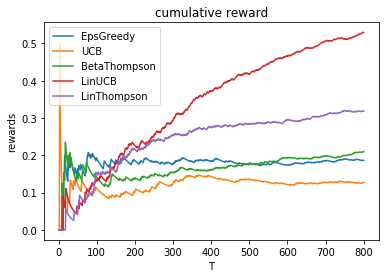

In [19]:
T = list(range(1,801))
results_EpsGreedy = []
results_UCB = []
results_BetaThompson = []
results_LinUCB = []
results_LinThompson = []

def cumulative_reward(mab):
    """Return cumulative reward of a mab in 800 rounds"""
    cumulative_rewards = []
    results = offlineEvaluate(mab, arms, rewards, contexts, 800)
    for i in range(len(results)):
        cumulative_rewards.append(np.mean(results[0:i]))
    return cumulative_rewards
    

mab = EpsGreedy(10, 0.05)
results_EpsGreedy = cumulative_reward(mab)
mab = UCB(10, 1.0)
results_UCB = cumulative_reward(mab)
mab = BetaThompson(10, 1.0, 1.0)
results_BetaThompson = cumulative_reward(mab)
mab = LinUCB(10, 10, 1.0)
results_LinUCB = cumulative_reward(mab)
mab = LinThompson(10, 10, 1.0)
results_LinThompson = cumulative_reward(mab)

plt.plot(T,results_EpsGreedy,label = 'EpsGreedy')
plt.plot(T,results_UCB,label  = 'UCB')
plt.plot(T,results_BetaThompson,label = 'BetaThompson')
plt.plot(T,results_LinUCB,label = 'LinUCB')
plt.plot(T,results_LinThompson ,label= 'LinThompson')
plt.xlabel('T')
plt.ylabel('rewards')
plt.title('cumulative reward')
plt.legend()
plt.show()


### 6.B.

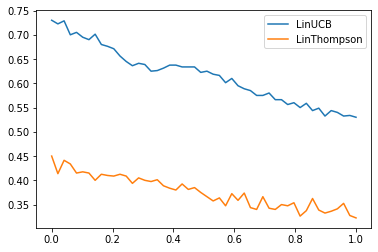

In [21]:
def gridSearch(mabS,start,end,num):
    
    """
    Arguments
    =========
    mabS : String, the mab to search parameters for
    start: float,start poing of searching range
    end: float,end point of searching range
    num: int,number of points in searching range
    
    """
        
    searchRange = np.linspace(start,end,num = num,endpoint=True)
    R = []
    for p in searchRange:
        mab = eval(mabS)(10, 10, p)
        R.append(np.mean(offlineEvaluate(mab, arms, rewards, contexts, 800)))
    return R
results_LinUCB = gridSearch('LinUCB',0.01,1,50)
results_LinThompson = gridSearch('LinThompson',0.01,1,50)
plt.plot(list(np.linspace(0,1,num =50 ,endpoint=True)),results_LinUCB,label = 'LinUCB')
plt.plot(list(np.linspace(0,1,num =50 ,endpoint=True)),results_LinThompson,label  = 'LinThompson')
plt.legend()
plt.show()
